<a href="https://colab.research.google.com/github/Y-Kanan/Time-Series-classification/blob/master/MyFastDtw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}



E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 131304 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.3-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.3-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.3-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz

# 读取文件
train_downloaded = drive.CreateFile({'id': '1cD9yo7c9bBeTOZaO5hUVegCXROHW84a0'})
train_downloaded.GetContentFile('tstrain.csv')
test_downloaded = drive.CreateFile({'id': '1Obbe1GkgH3FwhJriOY0LeAzb__HU_sHv'})
test_downloaded.GetContentFile('tstest.csv')
# 与平常read_csv无异
train_data = pd.read_csv('tstrain.csv',names=[i for i in range(97)])
test_data = pd.read_csv('tstest.csv',names=[i for i in range(97)])

168
400
[-0.187086   -0.187086   -0.187086   -0.187086   -0.187086   -0.187086
 -0.187086   -0.187086   -0.187086   -0.187086   -0.187086   -0.187086
 -0.187086   -0.187086   -0.187086   -0.187086   -0.187086   -0.187086
 -0.187086   -0.187086   -0.187086   -0.187086   -0.187086   -0.187086
 -0.187086   -0.187086   -0.187086   -0.187086   -0.187086   -0.187086
 -0.187086   -0.187086   -0.187086   -0.187086   -0.187086   -0.187086
 -0.187086   -0.187086   -0.187086   -0.187086   -0.187086   -0.187086
 -0.187086   -0.187086   -0.187086   -0.187086   -0.187086   -0.187086
 -0.187086   -0.187086   -0.187086   -0.187086   -0.187086   -0.187086
 -0.187086   -0.187086   -0.187086   -0.187086   -0.187086   -0.187086
 -0.187086   -0.187086   -0.187086   -0.187086   -0.187086   -0.187086
 -0.187086   -0.187086   -0.187086   -0.187086   -0.187086   -0.187086
 -0.187086   -0.187086   -0.187086   -0.187086   -0.187086   -0.187086
 -0.187086   -0.187086   -0.1226292   0.17813234  6.92398066  0.19962

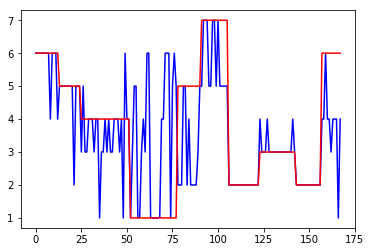

running time:  0:21:14.619172


In [11]:
#!/usr/bin/env python 
# -*- coding:utf-8 -*-
import numpy as np
import pandas as pd
import datetime
from sklearn import preprocessing
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cdist
from fastdtw import fastdtw
# import dtw
from matplotlib import pyplot as plt

def Mydtw(x,y): #x做列，y做行
    if np.ndim(x) == 1:
        x = x.reshape(-1, 1)
    if np.ndim(y) == 1:
        y = y.reshape(-1, 1)
    r, c = np.size(x), np.size(y)
    D0 = np.zeros((r + 1, c + 1))
    D0[0, 1:] = np.inf
    D0[1:, 0] = np.inf
    D1 = D0[1:, 1:]  # view
    C = D0.copy()
    #   求得D1为原始距离矩阵
    for i in range(r):
        for j in range(c):
            D1[i, j]=D0[i+1,j+1]=C[i+1,j+1]= np.abs(x[i]-y[j]) #曼哈顿城市距离
            C[i+1,j+1]+=min(C[i,j],C[i,j+1],C[i+1,j])   # 同时求得累计距离矩阵
    i, j = np.array(C.shape) - 2  #从倒数第二个数开始算路径
    path = [[i+1,j+1]]
    while (i > 0) or (j > 0):
        tb = np.argmin((C[i, j], C[i, j + 1], C[i + 1, j]))
        if tb == 0:
            path.append([i, j])
            i -= 1
            j -= 1
        elif tb == 1:
            path.append([i, j + 1])
            i -= 1
        else:  # (tb == 2):
            path.append([i + 1, j])
            j -= 1
    path.reverse()
    return C[-1,-1],path

  
def MyFastDtw(x,y,wrap):
    if np.ndim(x) == 1:
        x = x.reshape(-1, 1)
    if np.ndim(y) == 1:
        y = y.reshape(-1, 1)
    r, c = np.size(x), np.size(y)
    D0 = np.zeros((r + 1, c + 1))
    D0[0, 1:] = np.inf
    D0[1:, 0] = np.inf
    D1 = D0[1:, 1:]
    D0[1:, 1:] = cdist(x,y,'cityblock')
    C=D0.copy()
    for i in range(r):
        for j in range(c):
            minlist=[D0[i,j]]  #将所在节点周围wrap范围内的距离点存入一个列表中以求最小值
            for k in range(1,wrap+1):
                minlist+=[D0[min(i+k,r),j],D0[i,min(j+k,c)]]
            D1[i,j]+=min(minlist)  #将wrap范围内最小值找出并累加

    C[1:,1:]=D1.copy()  #C，D1为累计距离矩阵
    i, j = np.array(C.shape) - 2  #从倒数第二个数开始算路径
    path = [[i+1,j+1]]
    while (i > 0) or (j > 0):
        tb = np.argmin((C[i, j],C[i, j + 1], C[i + 1, j]))
        if tb == 0:
            path.append([i, j])
            i -= 1
            j -= 1
        elif tb == 1:
            path.append([i, j + 1])
            i -= 1
        else:  # (tb == 2):
            path.append([i + 1, j])
            j -= 1
    path.reverse()
    return C[-1,-1],path


# 程序运行开始时间记录
start = datetime.datetime.now()
# # 数据文件和当前脚本在不同目录下，所以要写完整路径
# train = r"C:\Users\Administrator\Desktop\Data\train14.csv"
# test = r"C:\Users\Administrator\Desktop\Data\test14.csv"
# # 读取训练集和测试集,读取的为dataframeg格式
# train_data = pd.read_csv(train,names=[i for i in range(97)])
# test_data = pd.read_csv(test,names=[i for i in range(97)])
# ----------- 预处理：z-标准化--------------
#选取除类别标签以外的数据切片，后均为array格式
z_train=preprocessing.scale(train_data.iloc[:,1:],axis=1) #axis=1,以行为单位运算
train_data.iloc[:,1:]=z_train
z_test=preprocessing.scale(test_data.iloc[:,1:],axis=1)
test_data.iloc[:,1:]=z_test

size_train=np.shape(z_train)
size_test=np.shape(z_test)

#d[i,j]为第i个训练集中的序列同第j个测试集中序列的DTW距离
d=np.zeros((size_test[0],size_train[0]))
# 分类结果储存在min矩阵中6*96 索引：最小距离，所对应的序号，分类结果，实际类别
result_min=np.full((6,test_data.shape[0]),np.inf)
test_row=test_data.shape[0]
train_row=train_data.shape[0]
print(test_row)
print(train_row)
print(z_train[0],'\n',type(z_train[0]),'\n',np.ndim(z_train[0]))
# # 对测试集到训练集序列进行距离计算
#
for i in range(test_data.shape[0]):
    for j in range(train_data.shape[0]):
        d[i,j],_=MyFastDtw(z_test[i],z_train[j],wrap=1)
        # d[j,i],_=fastdtw([z_test[print(z_test[0].shape)
        # # print(z_train[0].shape)i]],[z_train[j]],radius=14,dist=2)
        if d[i,j]<result_min[0,i]:
            result_min[0,i]=d[i,j] #最小距离
            result_min[1,i]=j      #编号
            num=j
            result_min[2, i] =train_data.iloc[j, 0] #分类结果
    # print(path)
    # print(result_min[0,i],'路径为：\n',fastpath)
    # path.append((i,num))
    # path.reverse()
    # print('最短距离：\n', d[-1, -1], '路径:\n', path)
    result_min[3, i] = test_data.iloc[i,0]   #实际类别
    result_min[4,i] = (result_min[2,i]==result_min[3,i]) #分类是否正确
accuracy = np.sum(result_min[4])/size_test[0]
print(result_min)
print('accuracy: ',accuracy)
plt.figure(1)
# x=[i for i in range(0,size_test[0])]
y1=result_min[2]
y2=result_min[3]
plt.plot(y1,'b',y2,'r')
plt.show()
end=datetime.datetime.now()
print('running time: ',end-start)
